## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on CIFAR-10 data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

## Imports and Parameters

In [1]:
import time
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import torch

This cell defines paramaters of the algorithm: 
- `eps0`: initial learning rate that is linearly annealed during training
- `N_hid`: number of hidden units that are displayed as an `Ky` by `Kx` array by the `draw_weights` function defined below
- `mu`: the mean of the gaussian distribution that initializes the weights
- `sigma`: the standard deviation of that gaussian 
- `Nep`: number of epochs
- `N_batch`: size of the minibatch
- `prec`: parameter that controls numerical precision of the weight updates
- `delta`: the strength of the anti-hebbian learning
- `p`: Lebesgue norm of the weights; `k` - ranking parameter. 
- `N_in`: number of input units
- `val_split`: the proportion of validation split

In [2]:
eps0 = 3e-2    # initial learning rate for the unsupervised part
Kx = 10
Ky = 10
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 2000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 1000     # number of epochs
N_batch = 1000  # size of the minibatch
prec = 1e-30
delta = 0.2    # Strength of the anti-hebbian learning
p = 2.0        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 3072     # input units
Nc = 10        # number of classes
val_split = 1/10

In [3]:
# Cuda Parameters
use_cuda = torch.cuda.is_available()
torch.cuda.empty_cache()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
# a utility function to shuffle training and testing samples
def shuffle(xt, yt, xv, yv):
    
    # xt, yt: training samples and labels
    # xv, yv: validation samples and labels
    
    pt = np.random.permutation(len(xt))
    pv = np.random.permutation(len(xv))
    return(xt[pt], yt[pt], xv[pv], yv[pv])

In [5]:
# move data from and to gpu

def detach(tensor):
    try:
        return tensor.cpu().detach().numpy()
    except:
        return tensor
    
def attach(tensor):
    try:
        return torch.from_numpy(tensor).float().to(device)
    except:
        print('could not move data to cuda')
        return tensor

## Data
Let's load the data from `keras`:
- Use `keras.datasets.cifar10.load_data()` to load the 45000 train and 5000 test samples.
- Reshape images to (#samples, 3x32x32) and labels to (#samples, 10)
- Split the train part to 45000 and 5000 validation samples

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(x_train.shape)
# reshape to (# samples, 784)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2] * x_train.shape[3])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2] * x_test.shape[3])

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train -= x_train.mean(axis=0, keepdims=True) 
x_test -= x_test.mean(axis=0, keepdims=True)
x_train /= np.linalg.norm(x_train, ord=2, axis=1, keepdims=True)
x_test /= np.linalg.norm(x_test, ord=2, axis=1, keepdims=True)

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

(50000, 32, 32, 3)
x_train shape: (45000, 3072)
y_train shape: (45000, 1)
x_val shape: (5000, 3072)
y_val shape: (5000, 1)
45000 train samples
10000 test samples


In [7]:
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test = x_test.shape[0]

## Weights visualization
To draw a heatmap of the weights a helper function is created:

In [8]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    Kw = int(np.sqrt(synapses.shape[1]//3)) # i.e. 32
    yy=0
    HM=np.zeros((Kw*Ky, Kw*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*Kw:(y+1)*Kw,x*Kw:(x+1)*Kw]=synapses[yy,:Kw*Kw*3].reshape(Kw, Kw, 3)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    tmp = (HM-HM.min())
    tmp /= tmp.max() 
    tmp *= 255
    tmp = tmp.astype(np.uint8)
    if ax is not None:
        im = ax.imshow(tmp)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(tmp.astype(np.uint8))
        plt.axis('off')
    fig.canvas.draw() 

## Forward pass of the unsupervised part
This is one step of the training and returns the changes that should be applied to the weights in one iteration. 

**Note:** In the testing phase, we don't need to compute `h` or `g` functions, so we just return the input currents.
- Given the inputs and the synapses (weights), compute the input currents `tot_input` = <W.v>
    - This is referred to `I` in the paper.
- If we're in the testing phase, return `tot_input`
- If we're in the training phase, go on to use the rankings in the input currents as proxies for the final `h` and return the changes that should be application 

In [12]:
def forward(inputs, synapses, p, N_hid, N_batch, training=True):
    N_in = inputs.shape[1]
    inputs = torch.transpose(inputs, 0, 1)
    sig = torch.sign(synapses).to(device)
    
    # with p=2, this is equal to <W.v> = I 
    tot_input = torch.mm(sig*torch.abs(synapses).pow(p-1), inputs)
    
    if training == False:
        return torch.transpose(tot_input, 0, 1)
    
    y = torch.argsort(tot_input, dim=0).to(device) # using tot_input (I) as proxy for h
    y1 = torch.zeros((N_hid, N_batch)).to(device)  # g(Q)
    y1[y[N_hid-1, :], np.arange(N_batch)] = 1.0    # g(max_activation in I) = 1
    y1[y[N_hid-k], np.arange(N_batch)] = -delta    # g(second max activation) = -delta


    xx = torch.sum(torch.mul(y1, tot_input), 1)    # g(Q) * <W, v>
    ds = torch.matmul(y1, torch.transpose(inputs, 0, 1)) - torch.mul(xx.reshape(xx.shape[0],1).repeat(1, N_in), synapses)
    nc = torch.max(torch.abs(ds))

    return ds, nc

## The unsupervised training of the hidden layer
This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

### Note
This will take some time, especially if the hidden layer is big (e.g. N_hid>500). If you want to see a demo, skip to the next cell to load the pre-trained weights.

If you do train the model yourself, make sure to comment the next cell so you don't replace the your trained weights with the pre-trained ones!

In [13]:
def train_weights(x_train, N_hid, N_batch, Nep=Nep, mu=0, sigma=1, device="cpu"):

    N_train, N_in = x_train.shape
    x_train = attach(x_train)
    synapses = (torch.randn(N_hid, N_in) * sigma + mu).to(device)
    eps0 = torch.tensor(4e-2).to(device)

    for nep in tqdm(range(Nep)):
        eps=eps0*(1-nep/Nep)

        for i in range(N_train//N_batch):
            inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i 
            ds, nc = forward(inputs, synapses, p, N_hid, N_batch)
            
            if nc < prec:
                nc = prec
            synapses += torch.mul(torch.div(ds, nc), eps)        
  
#         draw_weights(detach(synapses), Kx, Ky)
    
    return synapses

In [ ]:
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
print('using device: {}'.format(device))

start = time.time()

synapses = train_weights(x_train, N_hid, N_batch, Nep, device=device).to(device)

print('took {:.4f}s to run {} epochs'.format(time.time() - start, Nep))

## Saving or loading synapses
- If you want to save your own synapses from previous cell, uncomment and edit the first line
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1b-2FNqVQ1fN-eixeTO9WZin9eNl2gqou/view?usp=sharing)


In [29]:
# save your own model
np.save('./models/CIFAR10_synapses_hid{}_epoch{}_eps{}_p2_k2_batch{}.npy'.format(N_hid, Nep, eps0, N_batch), detach(synapses))

In [49]:
# load a pre-trained model
synapses = np.load('./models/CIFAR10_synapses_hid{}_epoch{}_eps{}_p2_k2_batch{}.npy'.format(N_hid, Nep, eps0, N_batch))

<IPython.core.display.Javascript object>


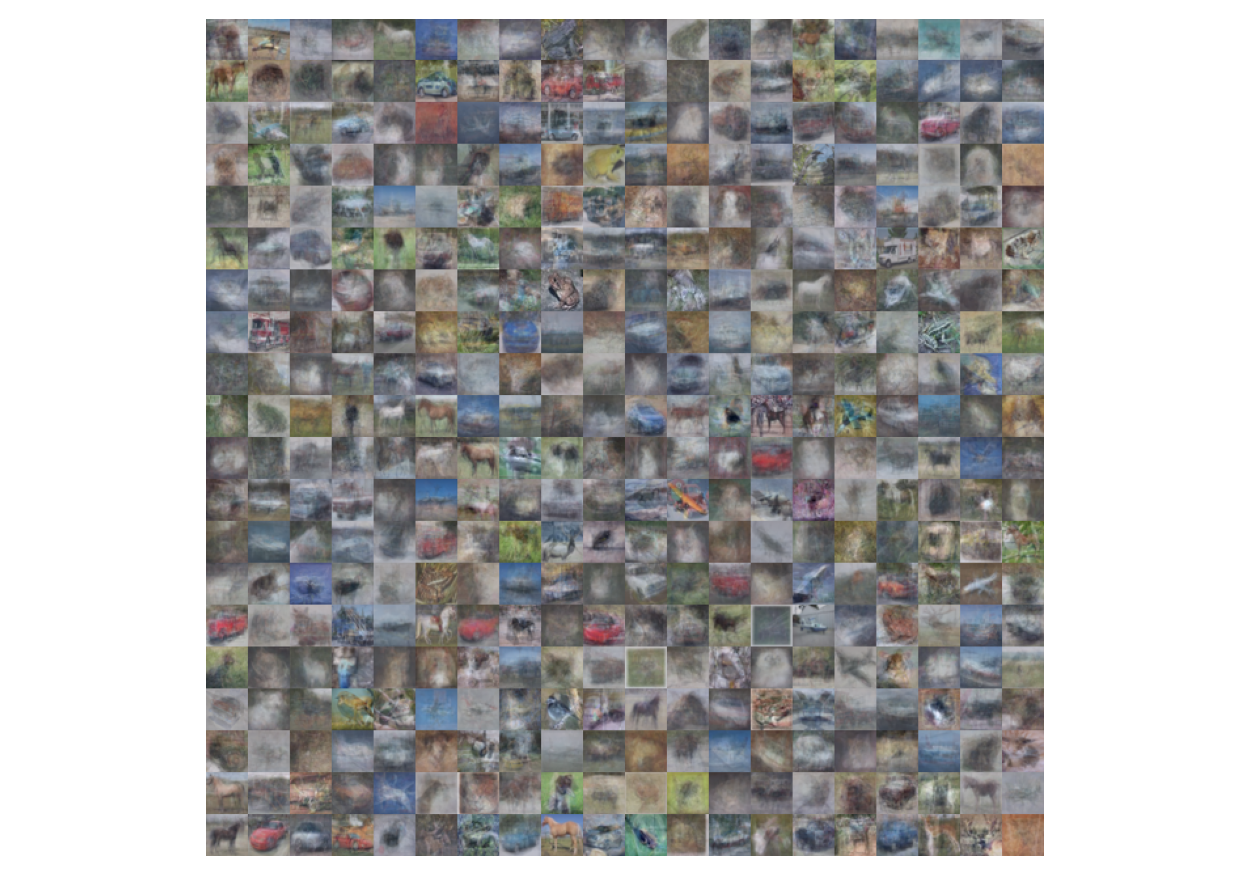

In [15]:
# %matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(10, 7))
draw_weights(detach(synapses), Kx*2, Ky*2)
plt.tight_layout()
# plt.savefig('CIFAR10_synapses_hid{}_epoch{}_eps{}_p2_k2_batch{}.pdf'.format(N_hid, Nep, eps0, N_batch))

In [16]:
def normalize(x):
    x_norm = x - np.mean(x, axis=1, keepdims=True)
    x_norm = x_norm / np.linalg.norm(x_norm, ord=2, axis=1, keepdims=True)
    return attach(x_norm)

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained with SGD to do digit recognition.

In [17]:
# Center and normalize input data to unit vectors  
synapses = attach(synapses)
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_test, training=False)

n=4.5
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n
x_hid_test = (x_hid_test * (x_hid_test>0)) ** n


In [18]:
x_train.shape

(45000, 3072)

In [19]:
# convert everything to numpy tensors
x_hid_train = detach(x_hid_train)
x_hid_val = detach(x_hid_val)
x_hid_test = detach(x_hid_test)

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with `softmax activation`
- Loss function is the `categorical cross-entropy`
- Optimizer is `Adam` with initial learning rate of 0.1 which decays exponentially every `20` epochs with a decay rate of `0.5`
- Batch size is `10` and number of epochs is `500`

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [ ]:
bio_model = keras.Sequential([
    tf.keras.layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.BatchNormalization(),
    layers.Activation('softmax')
])

print(bio_model.summary())

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=4e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

bio_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_test, y_test), batch_size=100, epochs=50, verbose=1)

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [ ]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
    layers.Activation("relu"),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation="softmax")
])

bp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=1000, epochs=20, verbose=1)

## Plot losses and accuracies

<IPython.core.display.Javascript object>


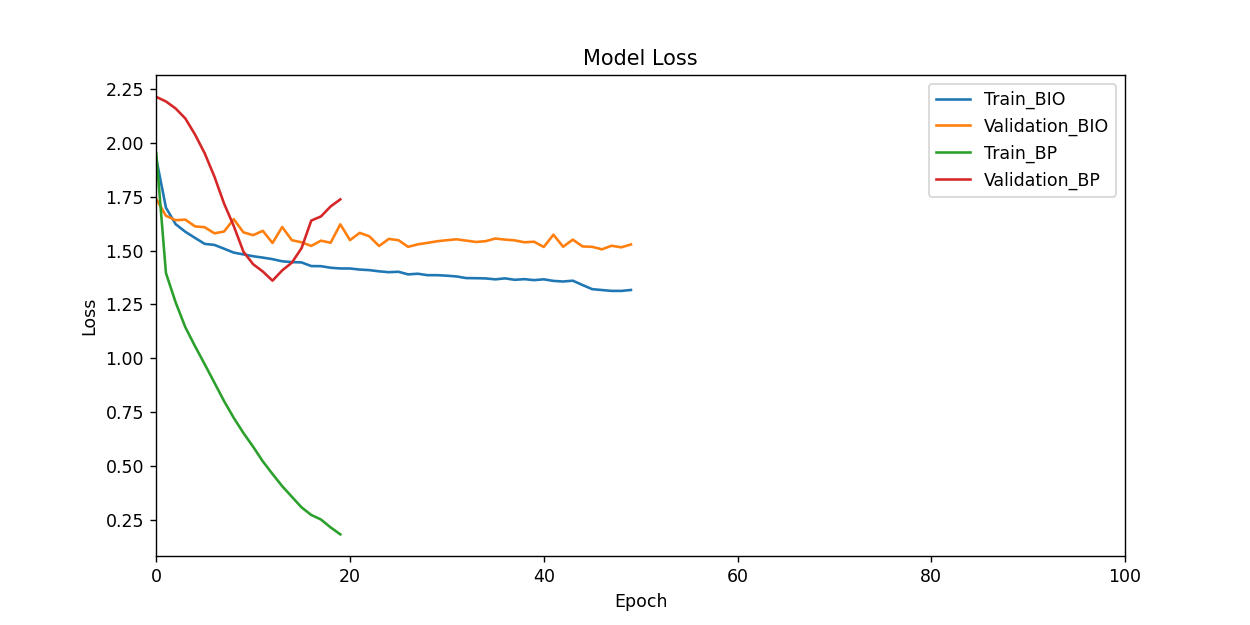

<IPython.core.display.Javascript object>


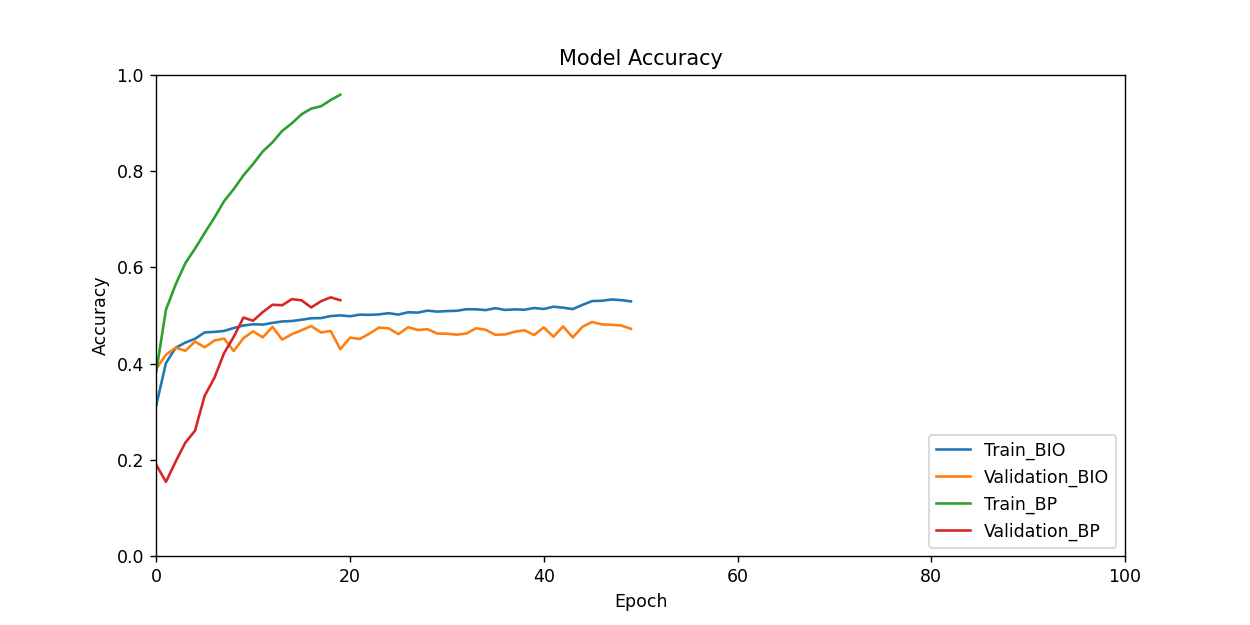

In [23]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.xlim(0, 100)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['accuracy'])
plt.plot(bio_history['val_accuracy'])

plt.plot(bp_history['accuracy'])
plt.plot(bp_history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

In [24]:
print('BIO best validation accuracy:', max(bio_history['val_accuracy']))
print('BP best validation accuracy:', max(bp_history['val_accuracy']))

BIO best validation accuracy: 0.4868
BP best validation accuracy: 0.538


## Plot weights of the BP model

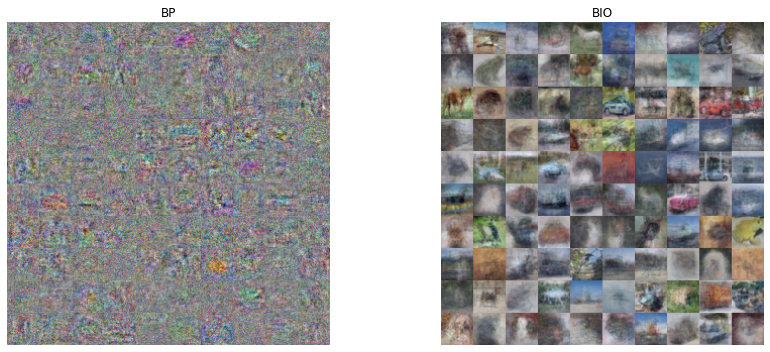

In [26]:
%matplotlib inline
# %matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, ax[0])
draw_weights(detach(synapses), Kx, Ky, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A linear model with the same architecture
If a linear model with one hidden layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [ ]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.Dense(N_hid),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(detach(x_train0), y_train, validation_data=(detach(x_val0), y_val), batch_size=1000, epochs=10, verbose=1)

In [28]:
print("Final Training Accuracy:", control_logs.history['accuracy'][-1])
print("Final Validation Accuracy:", control_logs.history['val_accuracy'][-1])

Final Training Accuracy: 0.3544
Final Validation Accuracy: 0.3622
